In [1]:
import joblib
import ml_help
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split

# Load historical data

In [2]:
flow_df = pd.read_csv("./data/yonge_flow.csv.zip")
weather_df = pd.read_csv("./data/weather_data.csv.zip")

flow_df["collectedAt"] = pd.to_datetime(flow_df["collectedAt"],utc=True)
flow_df["collectedAt"] = flow_df["collectedAt"].dt.floor(freq="t")
weather_df["collectedAt"] = pd.to_datetime(weather_df["collectedAt"],utc=True)
weather_df["collectedAt"] = weather_df["collectedAt"].dt.floor(freq="t")

flow_df.drop(['month', 'day', 'day_of_week', 'hour', 'minute'],inplace=True,axis=1)
weather_df.drop(['month', 'day', 'day_of_week', 'day_of_week_name', 'hour', 'minute', 'windDegree'],inplace=True,axis=1)

df = flow_df.merge(weather_df,on="collectedAt",how="inner")
df["Month"] = df.collectedAt.dt.month_name()
df["Day"] = df.collectedAt.dt.day
df["Weekday"] = df.collectedAt.dt.day_name()
df["Hour"] = df.collectedAt.dt.hour
df["Minute"] = df.collectedAt.dt.minute
df.drop("collectedAt",inplace=True,axis=1)

df.rename({
    'visibility': "Visibility",
    'temperature': "Temperature",
    'FeelsLike': "Feels Like",
    'humidity':"Humidity",
    'windSpeed': "Wind Speed",
    'cloudsAll': "Clouds All",
    'rain1h': "Rain (1h)",
    'snow1h': "Snow (1h)",
    'cloudy':"Cloudy",
    'clear':"Clear",
    'atmosphere':"Atmosphere",
    'snowy': "Snowy",
    'rainy':"Rainy",
}, axis=1, inplace=True)

categorical_attrs = ["Month", "Weekday"]
transformed_df_old = pd.get_dummies(df, columns=categorical_attrs, prefix="", prefix_sep="")
transformed_df_old = transformed_df_old.astype("float32")
transformed_df_old['May'] = 0
transformed_df_old = transformed_df_old.reindex(sorted(transformed_df_old.columns), axis=1)

X_old = transformed_df_old.drop("currentSpeed",axis=1)
y_old = transformed_df_old["currentSpeed"]

X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(X_old, y_old, test_size=0.20, random_state=42)

# Load future data

In [3]:
df_new = pd.read_csv("./data/202305_yonge_flow_weather.csv.zip")
df_new['August'] = 0
df_new['December'] = 0
df_new['February'] = 0
df_new['January'] = 0
df_new['July'] = 0
df_new['March'] = 0
df_new['November'] = 0
df_new['October'] = 0
df_new['September'] = 0
df_new = df_new.reindex(sorted(df_new.columns), axis=1)

X_new = df_new.drop(["currentSpeed"],axis=1)
y_new = df_new["currentSpeed"]

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.20, random_state=42)

# XGBoost

## Train on historical data

In [4]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

params = ml_help.params_to_dict("063_xgboost")
params["predictor"] = "cpu_predictor"
params["tree_method"] = "hist"

xgboost_pipeline = make_pipeline(StandardScaler(),xgb.XGBRegressor(**params))

print("Training XGBoost on historical data...")
start = time()
pipe = xgboost_pipeline.fit(X_train_old,y_train_old)
end = time()
print("Training XGBoost on historical data... OK!")

Training XGBoost on historical data...
Training XGBoost on historical data... OK!


## Test model using future data

In [5]:
y_pred_new = pipe.predict(X_test_new)
xgb_metrics_new = ml_help.get_metrics_reg("XGBoost",y_test_new,y_pred_new)
xgb_metrics_new["time_to_fit"] = end-start
xgb_metrics_new

{'model': 'XGBoost',
 'r2': 0.08739185077393541,
 'mae': 3.1783928566790642,
 'mse': 17.17021313988219,
 'rmse': 4.14369558967381,
 'mape': 0.39797158628801743,
 'time_to_fit': 19.756882905960083}

## Test model using historical data

In [6]:
y_pred_old = pipe.predict(X_test_old)
xgb_metrics_old = ml_help.get_metrics_reg("XGBoost",y_test_old,y_pred_old)
xgb_metrics_old["time_to_fit"] = end-start
xgb_metrics_old

{'model': 'XGBoost',
 'r2': 0.5046705767160051,
 'mae': 1.7695643,
 'mse': 5.704387,
 'rmse': 2.388386,
 'mape': 15727413000000.0,
 'time_to_fit': 19.756882905960083}

# Random Forest

## Train on historical data

In [7]:
from sklearn.ensemble import RandomForestRegressor

params = ml_help.params_to_dict("063_random_forest")

random_forest_pipeline = make_pipeline(StandardScaler(),RandomForestRegressor(**params))

print("Training Random Forest on historical data...")
start = time()
pipe = random_forest_pipeline.fit(X_train_old,y_train_old)
end = time()
print("Training Random Forest on historical data... OK!")

Training Random Forest on historical data...
Training Random Forest on historical data... OK!


## Test model using future data

In [8]:
y_pred_new = pipe.predict(X_test_new)
rf_metrics_new = ml_help.get_metrics_reg("Random Forest",y_test_new,y_pred_new)
rf_metrics_new["time_to_fit"] = end-start
rf_metrics_new

{'model': 'Random Forest',
 'r2': 0.08078472890229438,
 'mae': 3.149980203250623,
 'mse': 17.294522451467298,
 'rmse': 4.158668350742494,
 'mape': 0.3999797148602566,
 'time_to_fit': 28.08131742477417}

## Test model using historical data

In [9]:
y_pred_old = pipe.predict(X_test_old)
rf_metrics_old = ml_help.get_metrics_reg("Random Forest",y_test_old,y_pred_old)
rf_metrics_old["time_to_fit"] = end-start
rf_metrics_old

{'model': 'Random Forest',
 'r2': 0.43802852707397144,
 'mae': 1.9108618548271397,
 'mse': 6.4718607433796524,
 'rmse': 2.543985208954575,
 'mape': 15272147686531.004,
 'time_to_fit': 28.08131742477417}

# Decision Tree

## Train on historical data

In [10]:
from sklearn.tree import DecisionTreeRegressor

params = ml_help.params_to_dict("063_decision_tree")

decision_tree_pipeline = make_pipeline(StandardScaler(),DecisionTreeRegressor(**params))

print("Training Decision Tree on historical data...")
start = time()
pipe = decision_tree_pipeline.fit(X_train_old,y_train_old)
end = time()
print("Training Decision Tree on historical data... OK!")

Training Decision Tree on historical data...
Training Decision Tree on historical data... OK!


## Test model using future data

In [11]:
y_pred_new = pipe.predict(X_test_new)
dt_metrics_new = ml_help.get_metrics_reg("Decision Tree",y_test_new,y_pred_new)
dt_metrics_new["time_to_fit"] = end-start
dt_metrics_new

{'model': 'Decision Tree',
 'r2': 0.03965022682239394,
 'mae': 3.1932263845226267,
 'mse': 18.06844515719131,
 'rmse': 4.250699372714013,
 'mape': 0.40375596683814197,
 'time_to_fit': 0.22962093353271484}

## Test model using historical data

In [12]:
y_pred_old = pipe.predict(X_test_old)
dt_metrics_old = ml_help.get_metrics_reg("Decision Tree",y_test_old,y_pred_old)
dt_metrics_old["time_to_fit"] = end-start
dt_metrics_old

{'model': 'Decision Tree',
 'r2': 0.41576096072811874,
 'mae': 1.9337906130189524,
 'mse': 6.72830185369789,
 'rmse': 2.5938970399184873,
 'mape': 14225250620428.168,
 'time_to_fit': 0.22962093353271484}

# MLP

## Train model using historical data

In [13]:
from sklearn.neural_network import MLPRegressor

params = ml_help.params_to_dict("063_mlpr")

mlp_pipeline = make_pipeline(StandardScaler(),MLPRegressor(**params))

print("Training MLP on historical data...")
start = time()
pipe = mlp_pipeline.fit(X_train_old,y_train_old)
end = time()
print("Training MLP on historical data... OK!")

Training MLP on historical data...
Training MLP on historical data... OK!


/home/uncle_opal/miniconda3/envs/rapids/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Test model using future data

In [14]:
y_pred_new = pipe.predict(X_test_new)
mlp_metrics_new = ml_help.get_metrics_reg("MLP",y_test_new,y_pred_new)
mlp_metrics_new["time_to_fit"] = end-start
mlp_metrics_new

{'model': 'MLP',
 'r2': 0.2780158309257914,
 'mae': 2.907972720702809,
 'mse': 13.583729311575652,
 'rmse': 3.685611117789783,
 'mape': 0.33586210809267664,
 'time_to_fit': 105.51374745368958}

## Test model using historical data

In [15]:
y_pred_old = pipe.predict(X_test_old)
mlp_metrics_old = ml_help.get_metrics_reg("MLP",y_test_old,y_pred_old)
mlp_metrics_old["time_to_fit"] = end-start
mlp_metrics_old

{'model': 'MLP',
 'r2': 0.4781439043121658,
 'mae': 1.8688592978541796,
 'mse': 6.009877977952146,
 'rmse': 2.4515052473841754,
 'mape': 7849853942771.763,
 'time_to_fit': 105.51374745368958}

# Store metrics

In [18]:
metrics_new = pd.concat([pd.DataFrame(xgb_metrics_new,index=[0]),pd.DataFrame(rf_metrics_new,index=[0]),pd.DataFrame(dt_metrics_new,index=[0]),pd.DataFrame(mlp_metrics_new,index=[0])])
metrics_new.to_csv("./metrics/994_yonge_flow_weather_metrics_new.csv.zip",index=False,compression="zip")

metrics_old = pd.concat([pd.DataFrame(xgb_metrics_old,index=[0]),pd.DataFrame(rf_metrics_old,index=[0]),pd.DataFrame(dt_metrics_old,index=[0]),pd.DataFrame(mlp_metrics_old,index=[0])])
metrics_old.to_csv("./metrics/994_yonge_flow_weather_metrics_old.csv.zip",index=False,compression="zip")

# Plot metrics

In [19]:
metrics_new = pd.read_csv("./metrics/994_yonge_flow_weather_metrics_new.csv.zip")
metrics_new.at[0,"model"] = "XGBoost FX"
metrics_new.at[1,"model"] = "Random Forest FX"
metrics_new.at[2,"model"] = "Decision Tree FX"
metrics_new.at[3,"model"] = "MLP FX"
metrics_new

,model,r2,mae,mse,rmse,mape,time_to_fit
0,XGBoost FX,0.087392,3.178393,17.170213,4.143696,0.397972,19.756883
1,Random Forest FX,0.080785,3.149980,17.294522,4.158668,0.399980,28.081317
2,Decision Tree FX,0.039650,3.193226,18.068445,4.250699,0.403756,0.229621
3,MLP FX,0.278016,2.907973,13.583729,3.685611,0.335862,105.513747


In [20]:
metrics_old = pd.read_csv("./metrics/994_yonge_flow_weather_metrics_old.csv.zip")
metrics_old

,model,r2,mae,mse,rmse,mape,time_to_fit
0,XGBoost,0.504671,1.769564,5.704387,2.388386,1.572741e+13,19.756883
1,Random Forest,0.438029,1.910862,6.471861,2.543985,1.527215e+13,28.081317
2,Decision Tree,0.415761,1.933791,6.728302,2.593897,1.422525e+13,0.229621
3,MLP,0.478144,1.868859,6.009878,2.451505,7.849854e+12,105.513747


In [21]:
metrics = pd.concat([metrics_old, metrics_new])
metrics.sort_values(by="r2", ascending=False, inplace=True)
metrics

,model,r2,mae,mse,rmse,mape,time_to_fit
0,XGBoost,0.504671,1.769564,5.704387,2.388386,1.572741e+13,19.756883
3,MLP,0.478144,1.868859,6.009878,2.451505,7.849854e+12,105.513747
1,Random Forest,0.438029,1.910862,6.471861,2.543985,1.527215e+13,28.081317
2,Decision Tree,0.415761,1.933791,6.728302,2.593897,1.422525e+13,0.229621
3,MLP FX,0.278016,2.907973,13.583729,3.685611,3.358621e-01,105.513747
0,XGBoost FX,0.087392,3.178393,17.170213,4.143696,3.979716e-01,19.756883
1,Random Forest FX,0.080785,3.149980,17.294522,4.158668,3.999797e-01,28.081317
2,Decision Tree FX,0.039650,3.193226,18.068445,4.250699,4.037560e-01,0.229621


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


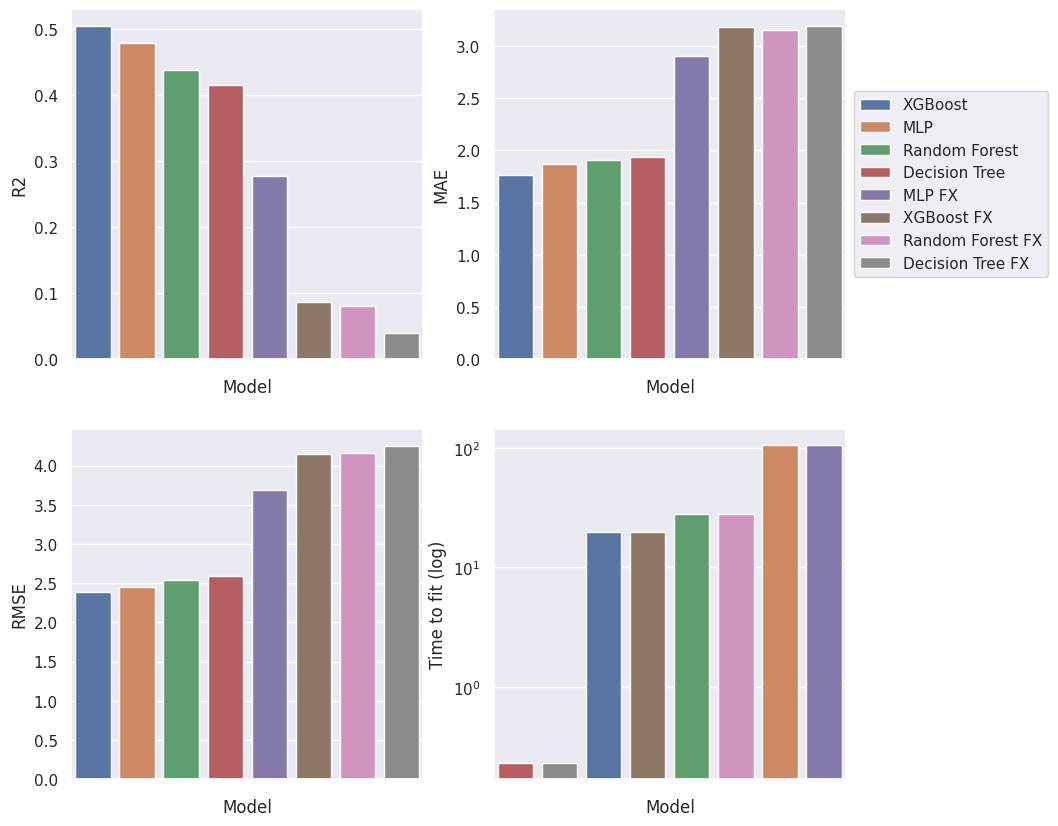

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ttf_order = list(metrics.sort_values(by="time_to_fit")["model"])

sns.barplot(ax=axes[0, 0], data=metrics, x='model', y='r2',hue="model",dodge=False)
sns.barplot(ax=axes[0, 1], data=metrics, x='model', y='mae',hue="model",dodge=False)
sns.barplot(ax=axes[1, 0], data=metrics, x='model', y='rmse',hue="model",dodge=False)
sns.barplot(ax=axes[1, 1], data=metrics, x='model', y='time_to_fit',hue="model",dodge=False, order=ttf_order)

axes[0, 0].set(xlabel="Model",xticklabels=[])
axes[0, 0].set(ylabel="R2")
axes[0, 0].get_legend().remove()

axes[0, 1].set(xlabel="Model",xticklabels=[])
axes[0, 1].set(ylabel="MAE")
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axes[1, 0].set(xlabel="Model",xticklabels=[])
axes[1, 0].set(ylabel="RMSE")
axes[1, 0].get_legend().remove()

axes[1, 1].set(xlabel="Model",xticklabels=[])
axes[1, 1].set(ylabel="Time to fit (log)", yscale="log")
axes[1, 1].get_legend().remove()

plt.savefig("./plots/994_yonge_flow_weather_metrics.eps",format="eps",bbox_inches="tight")
plt.savefig("./plots/994_yonge_flow_weather_metrics.png",bbox_inches="tight")
plt.savefig("./plots/994_yonge_flow_weather_metrics.pdf",bbox_inches="tight")